In [1]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

### Importing and preparing training data

In [2]:
df = pd.read_csv('data/BS_training.csv')
df.head()

,Unnamed: 0,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,0,206.484182,194.386150,1.093151,0.005674,0.862692,0.058898,79.434285
1,1,79.581809,73.926431,0.843836,0.020428,0.759562,0.080634,24.975516
2,2,130.957110,154.101232,1.326027,0.019181,0.606436,0.042031,28.927743
3,3,53.020511,58.598175,0.791781,0.028475,0.572696,0.036566,8.573626
4,4,455.190704,529.570396,0.501370,0.009074,0.090578,0.044426,0.210253


In [3]:
df = df.drop(['Unnamed: 0'], axis= 1)

#### Normalizing the data (as done in Culkin and Das)

Here we take advantage that the Black-Scholes formula is linear homegenous in $C(S,K)$, so we can normalize as follows:

$C(S,K)/K = C(S/K,1)$

In [4]:
df["Stock Price"] = df["Stock Price"]/df["Strike Price"]
df["Call Price"] = df["Call Price"]/df["Strike Price"]
df["Strike Price"] = df["Strike Price"]/df["Strike Price"]
df.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,1.062237,1.0,1.093151,0.005674,0.862692,0.058898,0.408642
1,1.076500,1.0,0.843836,0.020428,0.759562,0.080634,0.337843
2,0.849812,1.0,1.326027,0.019181,0.606436,0.042031,0.187719
3,0.904815,1.0,0.791781,0.028475,0.572696,0.036566,0.146312
4,0.859547,1.0,0.501370,0.009074,0.090578,0.044426,0.000397


In [5]:
np.random.seed(32)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Call Price', axis=1), 
                                                    df['Call Price'], test_size=0.2)

mlp = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=True,
                   max_iter= 10) 

In [6]:
np.random.seed(32)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.00035572
Iteration 2, loss = 0.00009492
Iteration 3, loss = 0.00006483
Iteration 4, loss = 0.00004711
Iteration 5, loss = 0.00003950
Iteration 6, loss = 0.00003412
Iteration 7, loss = 0.00002997
Iteration 8, loss = 0.00002729
Iteration 9, loss = 0.00002570
Iteration 10, loss = 0.00002444


/home/pradyumna/anaconda3/envs/ml_dl/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(batch_size=64, hidden_layer_sizes=(100, 100, 100, 100),
             max_iter=10, shuffle=False, verbose=True)

In [7]:
# Save First Fitted Model
filename = 'models/BS_model.sav'
pickle.dump(mlp, open(filename, 'wb'))

## Analysis and visualizations 
We start by exploring the most basic performance metric for every regression problem: $R^2$

In [8]:
# Load the model (in case no training is necessary)
filename = 'models/BS_model.sav'
mlp = pickle.load(open(filename, 'rb'))

In [9]:
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 0.999761
Test set score: 0.999759


We can see that the model produced very promising results from the simulated data. While the results show that the algorithm is able to learn option pricing mechanism, we cannot draw any significant conclusion that it can produce meaningful results in real life situation.

We can visualize the succes of the model in the graph below:

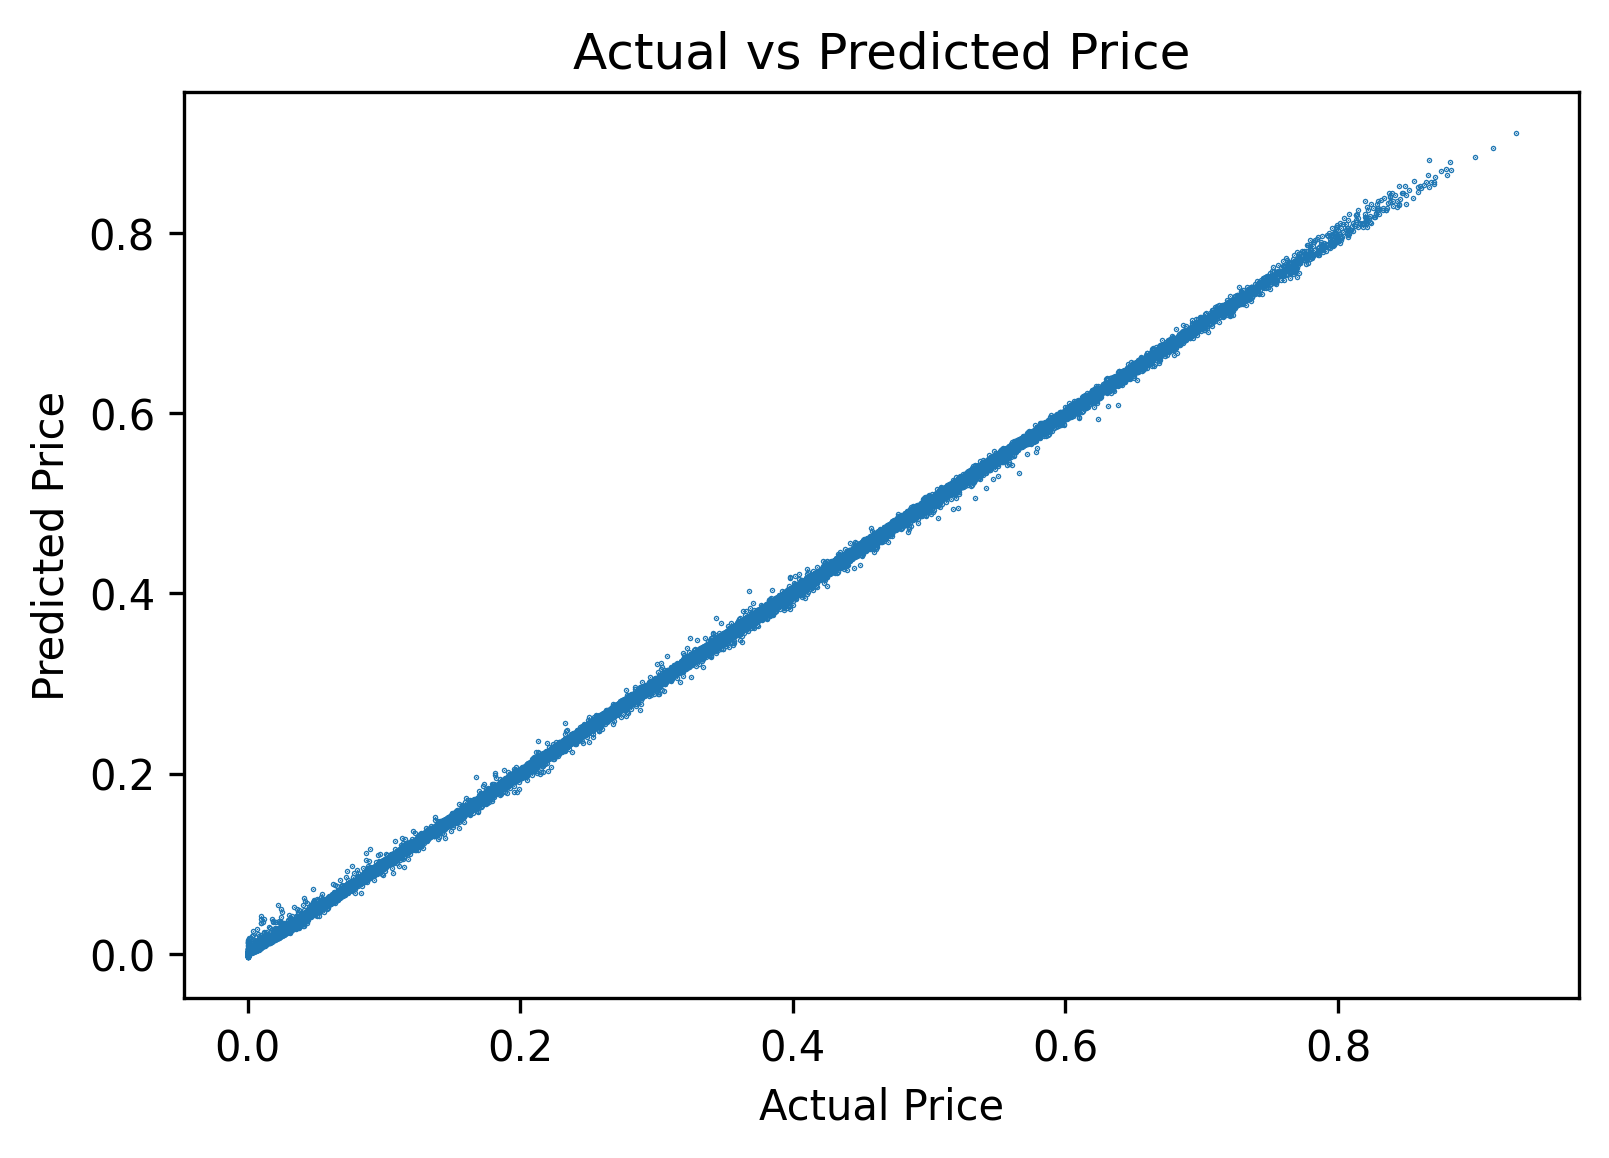

In [10]:
preds_test = mlp.predict(X_test)
plt.scatter(y_test, preds_test, s= 0.1)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

We can also explore the distribution of both the in-sample and out of sample error:

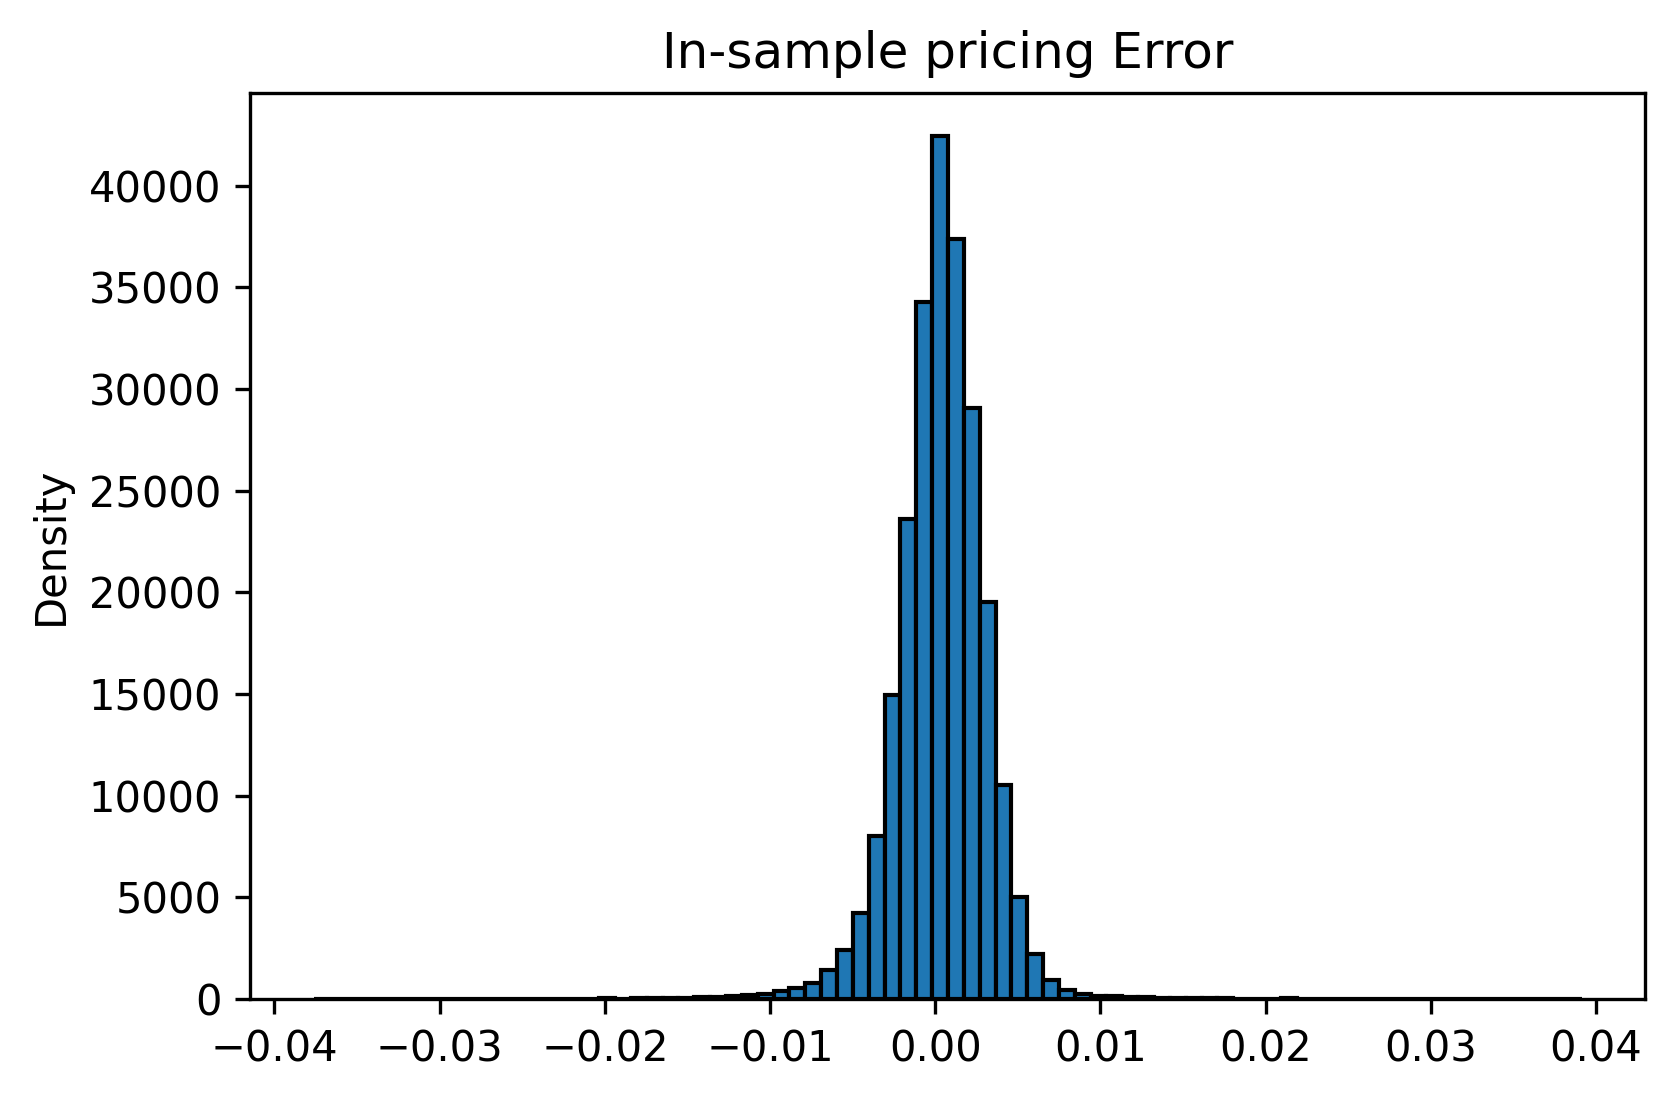

In [11]:
# Panel 1: In-sample Pricing Error
preds_train= mlp.predict(X_train)
pricing_error_train = preds_train - y_train
plt.hist(pricing_error_train, bins= 80, edgecolor='black')
plt.title("In-sample pricing Error")
plt.ylabel("Density")
plt.show()

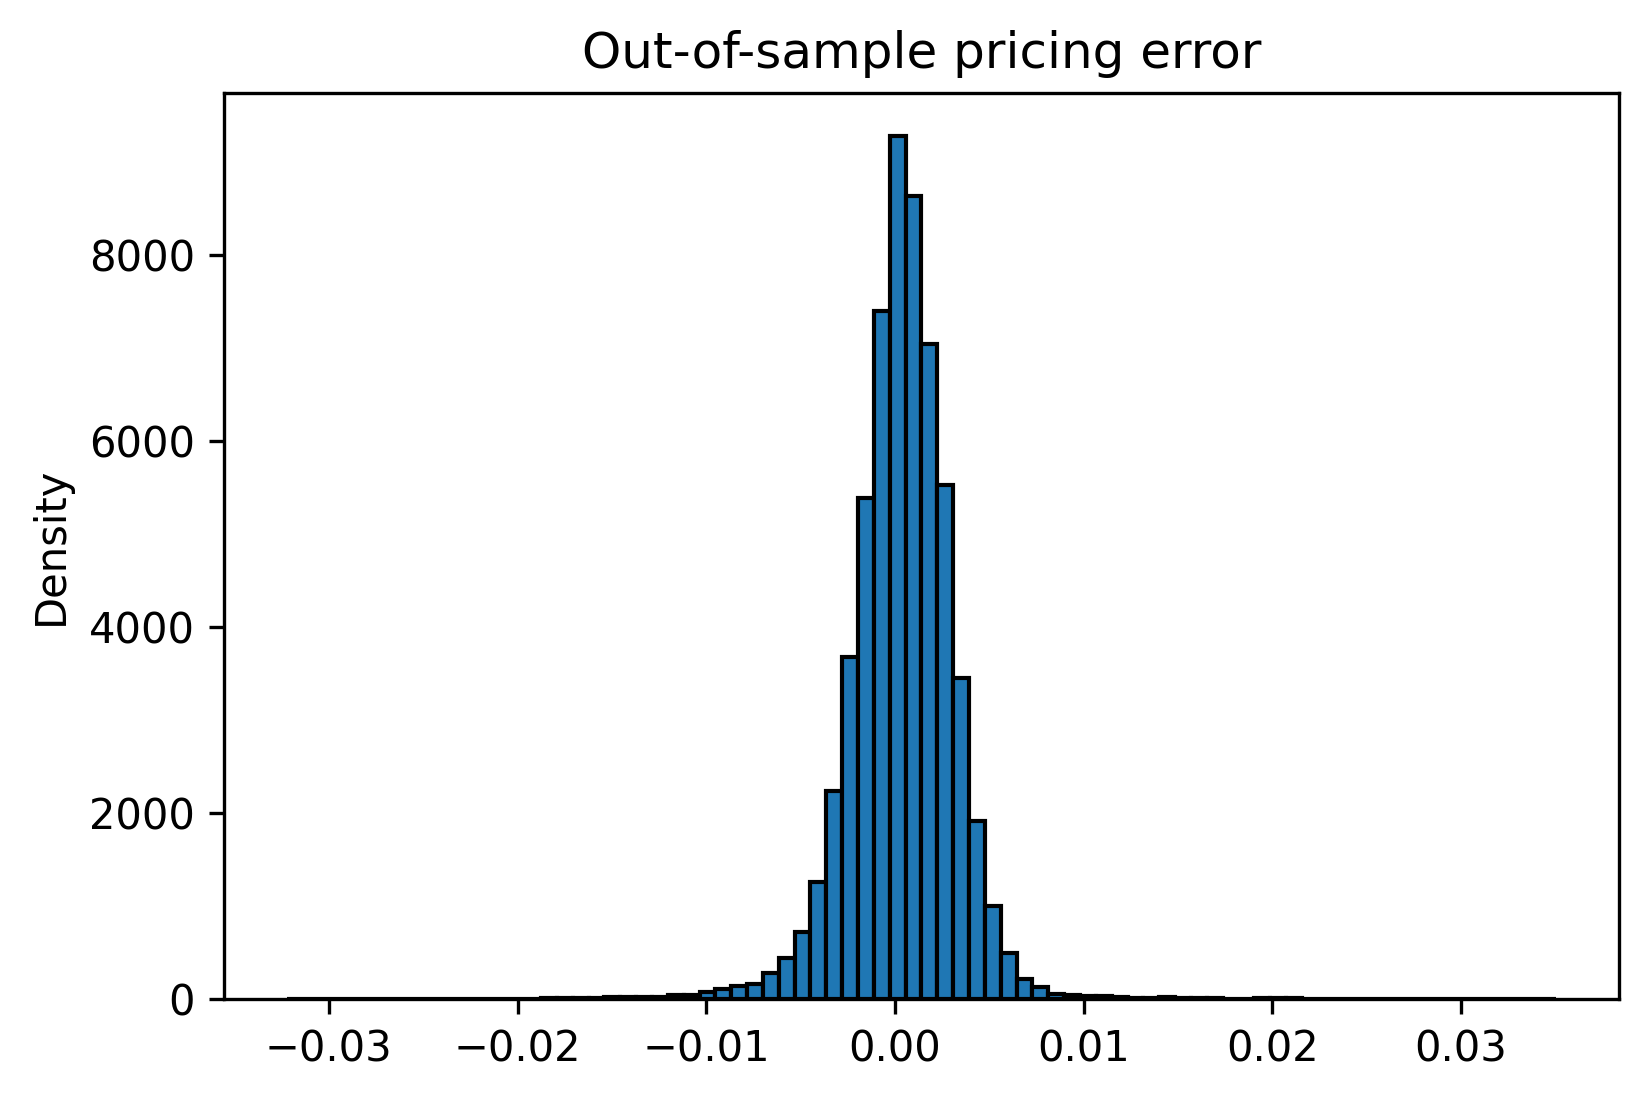

In [12]:
preds_test= mlp.predict(X_test)
pricing_error_test = preds_test - y_test
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("Out-of-sample pricing error")
plt.ylabel("Density")
plt.show()

In [13]:
rmse = mean_squared_error(preds_test, y_test)**0.5; rmse # root mean squared error
print("RMSE: %.4f" % rmse)

RMSE: 0.0028


In [14]:
a = pd.DataFrame([stats.describe(pricing_error_train)])
a.style.hide_index().set_table_attributes("style='display:inline'").set_caption('Descriptive Statistics of Pricing Error in Training Set - Simulated')


nobs,minmax,mean,variance,skewness,kurtosis
240000,"(-0.037616157352655444, 0.03916101878362214)",0.000394,0.000007,-0.127269,8.338279


In [15]:
b = pd.DataFrame([stats.describe(pricing_error_test)])
b.style.hide_index().set_table_attributes("style='display:inline'").set_caption('Descriptive Statistics of Pricing Error in Test Set - Simulated')

nobs,minmax,mean,variance,skewness,kurtosis
60000,"(-0.03219823219329265, 0.03501907496228146)",0.000390,0.000007,-0.186914,8.438351


## Validating with real data
So far, we have observed the behavior of the model using the synthetic data. Though the use of synthetic data has allowed us to learn the Black-Scholes model quite accurately, we have yet to see how the model performs using real data. Plus, we could also gauge whether models trained in real data are able to better price options in the market.

Nonetheless, it is worth noting that a common option trading strategy is to determine whether an option is undervalued or fairly valued with respect to the market's price and the price outputed by Black-Scholes. With this in mind, if our model misprices an option with a higher price, it could be an indicator that said option is undervalued

**Important**: by the time the data  for this article was collected, the current risk-free rate was 0.88%



## S&P500 Data

In [16]:
snp = pd.read_csv('data/SNP.csv')
snp= snp.dropna()
snp1 = snp.copy()
snp["Stock Price"] = snp["Stock Price"]/snp["Strike Price"]
snp["Call Price"] = snp["Call Price"]/snp["Strike Price"]
snp["Strike Price"] = snp["Strike Price"]/snp["Strike Price"]
snp.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,21.990000,1.0,0.005616,0.0275,0.3434,0.0088,22.600000
1,4.398000,1.0,0.005616,0.0275,0.3434,0.0088,2.420000
2,3.141429,1.0,0.005616,0.0275,0.3434,0.0088,1.571429
3,2.443333,1.0,0.005616,0.0275,0.3434,0.0088,1.233333
4,2.199000,1.0,0.005616,0.0275,0.3434,0.0088,1.260000


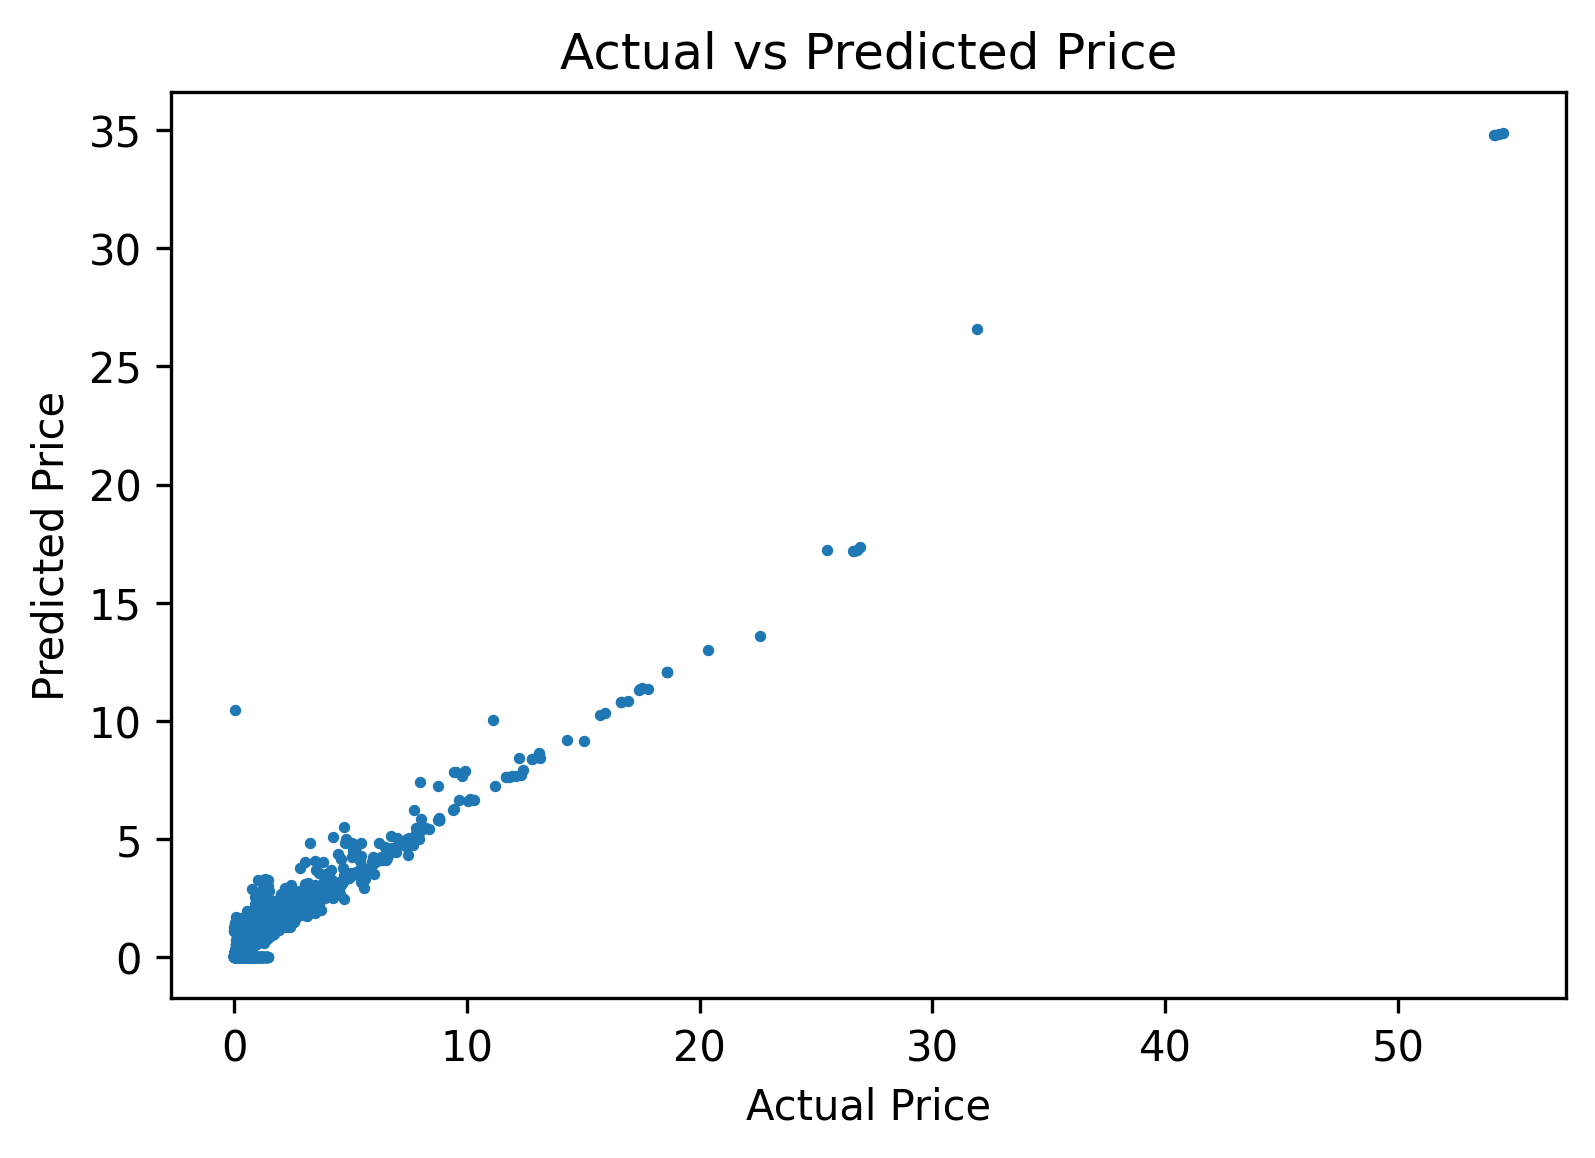

In [17]:
X_snp = snp.drop('Call Price', axis=1)
Y_snp = snp['Call Price']
preds_snp= mlp.predict(X_snp)
plt.scatter(Y_snp, preds_snp, s=3)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

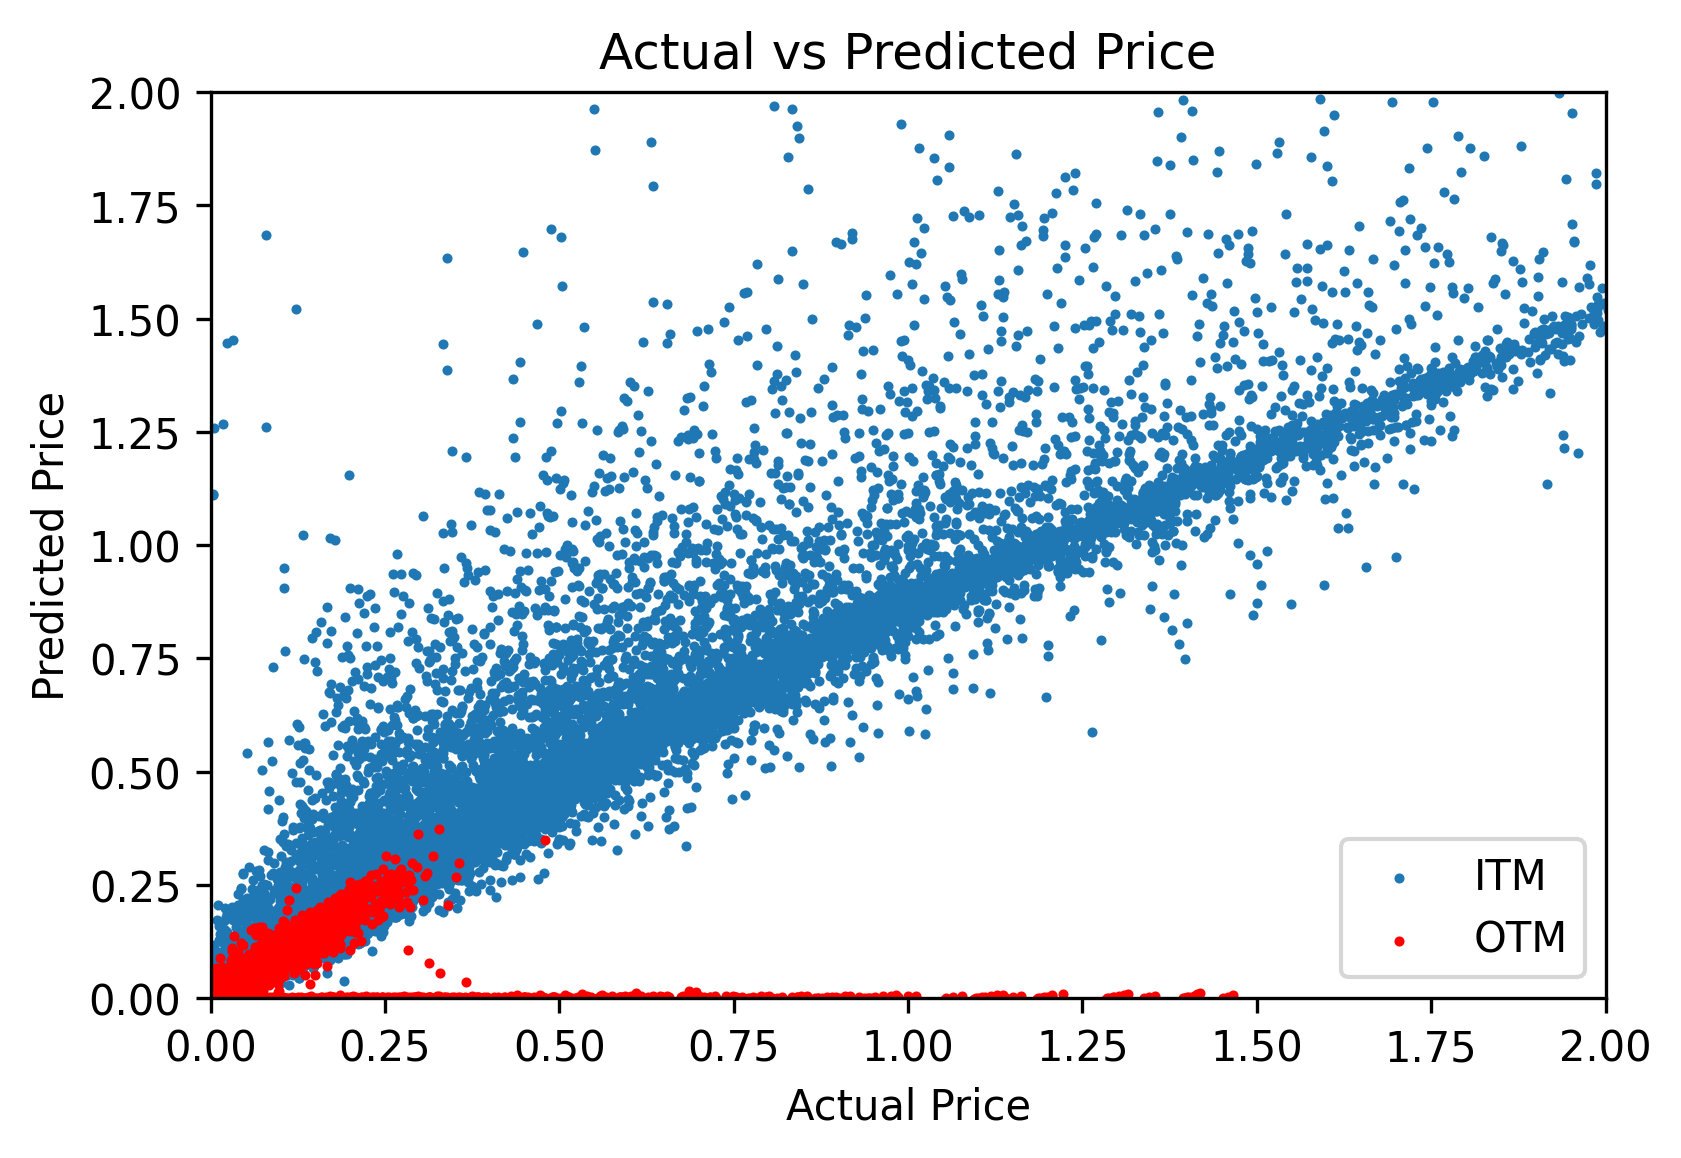

In [18]:
X_snp_itm = snp[snp['Strike Price'] < snp['Stock Price']]
X_snp_otm = snp[snp['Strike Price'] >= snp['Stock Price']] 
Y_snp_itm = X_snp_itm['Call Price']
Y_snp_otm = X_snp_otm['Call Price']
plt.scatter(Y_snp_itm, mlp.predict(X_snp_itm.drop('Call Price', axis=1)), s=2)
plt.scatter(Y_snp_otm, mlp.predict(X_snp_otm.drop('Call Price', axis=1)), c='r', s=2)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.legend(['ITM', 'OTM'])
plt.show()

The above graph exhibits what we have discussed in the above. Furthermore, while a variation is relatively higher, the model seems to find some success. In fact, we can see that $R^2$ value is:

In [19]:
print("R-Squared Value: %.4f" %r2_score(Y_snp, preds_snp))

R-Squared Value: 0.8802


### NIFTY50

,Unnamed: 0,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,0,0.870456,1.0,0.005616,0.0275,0.3434,0.0088,0.001823
1,1,1.154401,1.0,0.005616,0.0275,0.3434,0.0088,0.001294
2,2,0.888366,1.0,0.005616,0.0275,0.3434,0.0088,0.000905
3,3,0.884725,1.0,0.005616,0.0275,0.3434,0.0088,0.000910
4,4,0.881114,1.0,0.005616,0.0275,0.3434,0.0088,0.001029


In [33]:
snp = snp.drop('Unnamed: 0',axis=1)

In [34]:
snp

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,0.870456,1.0,0.005616,0.0275,0.3434,0.0088,0.001823
1,1.154401,1.0,0.005616,0.0275,0.3434,0.0088,0.001294
2,0.888366,1.0,0.005616,0.0275,0.3434,0.0088,0.000905
3,0.884725,1.0,0.005616,0.0275,0.3434,0.0088,0.000910
4,0.881114,1.0,0.005616,0.0275,0.3434,0.0088,0.001029
...,...,...,...,...,...,...,...
24247,1.101781,1.0,0.082086,0.0000,0.3116,0.0088,0.032093
24248,1.098145,1.0,0.082086,0.0000,0.3116,0.0088,0.030904
24249,1.094533,1.0,0.082086,0.0000,0.3116,0.0088,0.032336
24250,1.112836,1.0,0.082086,0.0000,0.3116,0.0088,0.031686


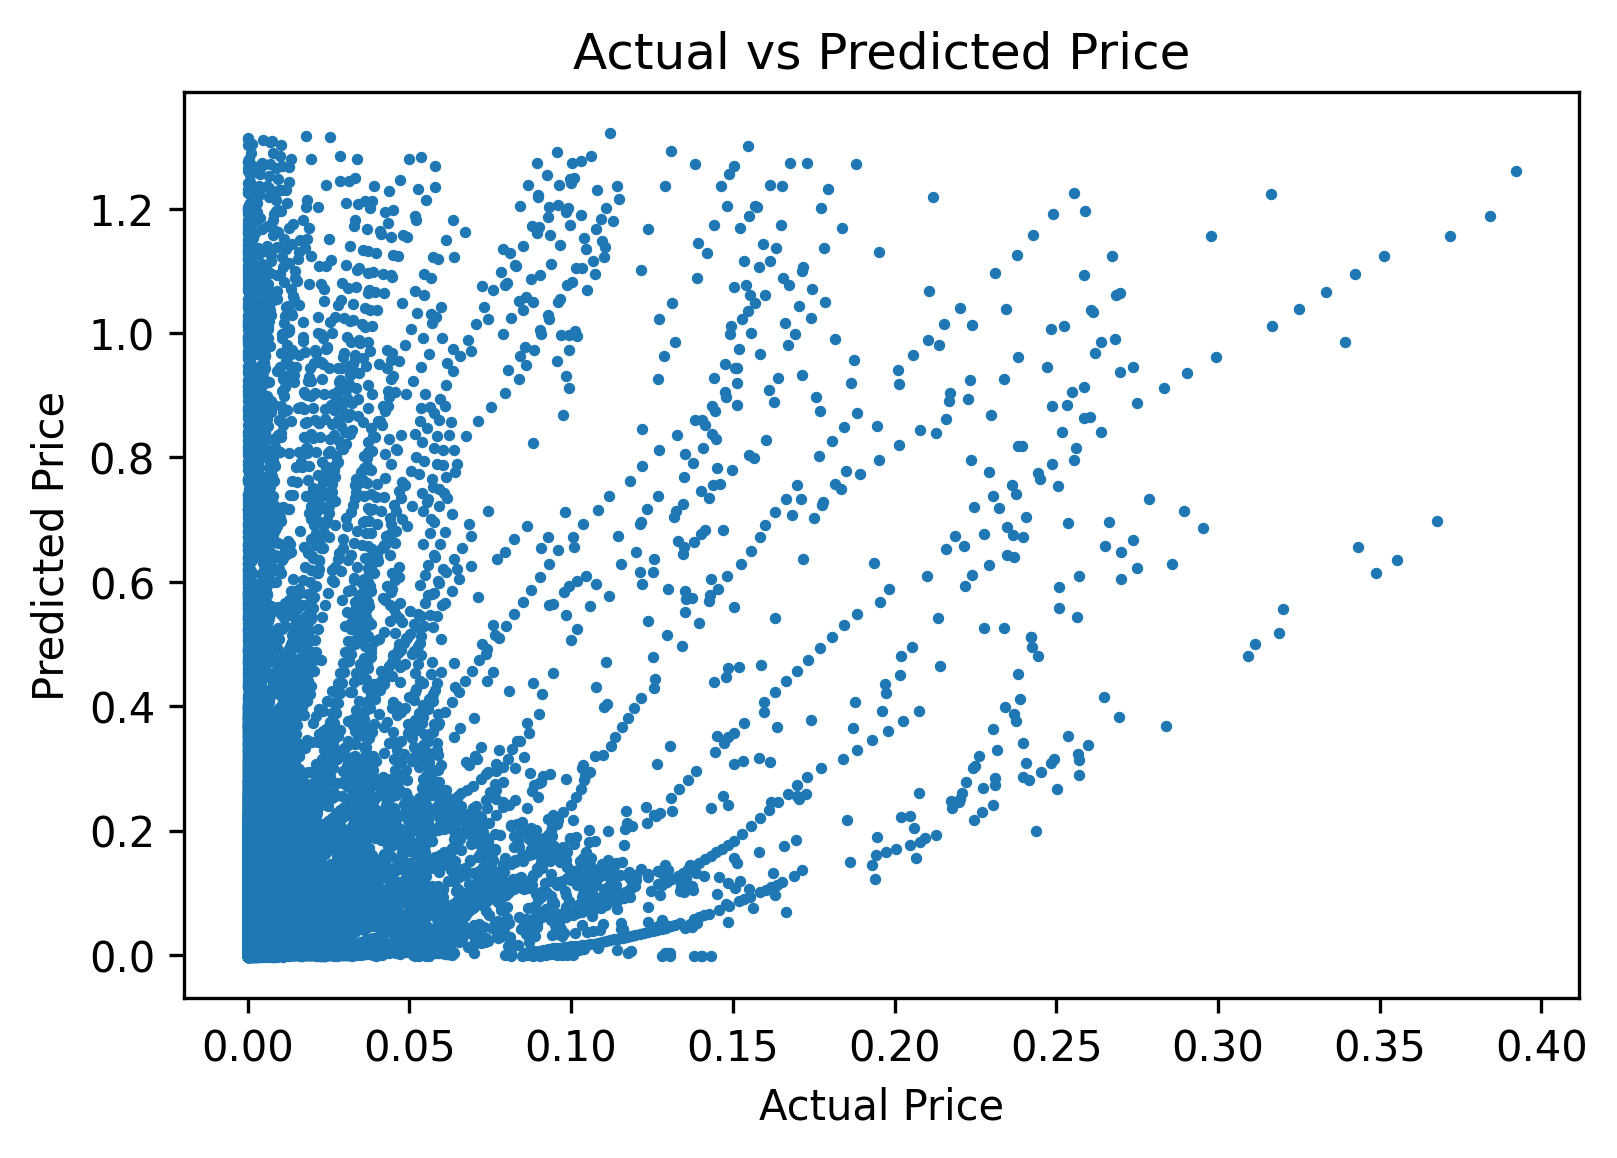

In [35]:
X_snp = snp.drop('Call Price', axis=1)
Y_snp = snp['Call Price']
preds_snp= mlp.predict(X_snp)
plt.scatter(Y_snp, preds_snp,s=3)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

In [36]:
snp['Call Price'] = Y_snp

In [37]:
snp.to_csv('finaldata.csv')